In [37]:
!pip install Munkres

In [38]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
from munkres import Munkres

**I - Data generation and manipulation**

In this practical session we will use two datasets :
- a first simple one, to understand how the SPA iterations work ;
- a real hyperspectral one, called urban.
Urban is one of the most widely used hyperspectral data used for hyperspectral unmixing studies. There are 307 x 307 pixels, each of which corresponds to a 2 x 2 m2 area. There are 210 wavelengths ranging from 400 nm  to 2500 nm, resulting in a spectral resolution of 10 nm. After the channels 1--4, 76, 87, 101--111, 136--153 and 198--210 are removed (due to dense water vapor and atmospheric effects), we obtain 162  channels.
Interestingly enough, a ground truth have been established. The one we will use contains 6 endmembers (i.e. sources).

**1) Simple dataset**

We propose to generate a very simple dataset, for visual purposes, as follows:
- the mixing matrix **A** will be a m x n matrix with its coefficients generated randomly in [0,10]. When you obtain such a realisation, verify that **A** is not too badly conditioned.
- the source matrix **S** will be a n x t matrix with random coefficients in [0,1] but will be scalled so that the l1-norm of each of its columns sum to 1.
- There will be no noise.

A conditioning 8.896421276014697


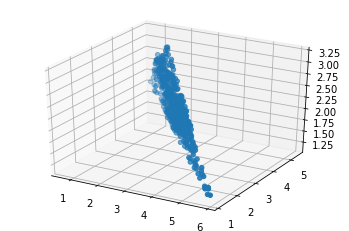

In [39]:
# TO DO : generate A according to the above description.
# TO DO : compute the condition number of A. What would be the issue with an ill-conditioned mixing matrix?
# TO DO : generate S according to the above conditions.
# TO DO : generate X with a linear mixing

n = 3
m = 3
t = 500

A_toy = np.random.rand(m,n)*10
cond = np.linalg.cond(A_toy)
while cond>20:
  A_toy = np.random.rand(m,n)*10
  cond = np.linalg.cond(A_toy)
print("A conditioning",cond)

S_toy = np.random.rand(n,t)
S_toy = S_toy/np.linalg.norm(S_toy,1,axis=0)

X_toy = A_toy@S_toy


fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(X_toy[0,:],X_toy[1,:],X_toy[2,:])

<blockquote>The problem with a bad conditioned matrix is that it’s really sensitive to noise and roundoffs errors. </blockquote>

**2) Real hyperspectral data set** 

First, upload in your working environment the two files Urban.mat and end6_groundTruth.mat, which can be found at https://partage.imt.fr/index.php/s/F7cRFrAre5neA9o

Here, we will use the "Urban" dataset:
- The data matrix **X = AS + N**, which has been acquired by a true sensor ;
- The groundtruth **S_gt**, which corresponds to the "true" abundances (sur groundtruth can for instance be found by on earth geological inquiries). Note that having access to **S_gt** is exceptional: for most other datasets, it would be unknown.

In [40]:
!wget -O myfile.zip https://partage.imt.fr/index.php/s/F7cRFrAre5neA9o/download
!unzip myfile.zipy

--2021-06-02 19:51:40--  https://partage.imt.fr/index.php/s/F7cRFrAre5neA9o/download
Resolving partage.imt.fr (partage.imt.fr)... 193.48.235.12
Connecting to partage.imt.fr (partage.imt.fr)|193.48.235.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘myfile.zip’

myfile.zip              [      <=>           ]  18.91M  3.30MB/s    in 5.6s    

2021-06-02 19:51:46 (3.40 MB/s) - ‘myfile.zip’ saved [19828316]

Archive:  myfile.zip
replace IMA 207 TP 2/end6_groundTruth.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: IMA 207 TP 2/end6_groundTruth.mat  
replace IMA 207 TP 2/Urban.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: IMA 207 TP 2/Urban.mat  


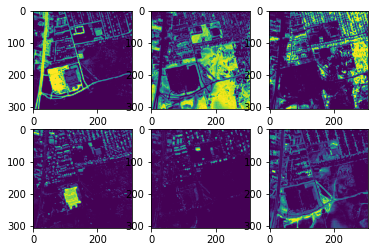

In [41]:
data = sci.loadmat("IMA 207 TP 2/Urban.mat")
X = data['X']
X = X.astype(float) # Please take care that the data matrix must be cast to float in Python, for subsequential operations

gt = sci.loadmat("IMA 207 TP 2/end6_groundTruth.mat")
abundances = gt['A']

nCol = 307
nRow = 307

plt.figure()
#TO DO : try to interpret the abundances that you see. Hint : the 6 sources are usually called ['Grass','Road','Rooftop (2)','Dirt','Trees','Rooftop (1)']. Associate a name to each endmember.
for ii in range(6): 
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(abundances[ii,:].reshape(nCol,nRow))
    
    #plt.title(names[ii])


<blockqute>Just analysing the images plotted above, I would say that: $S_0$ corresponds to the road; $S_1$ corresponds to grass; $S_2$ corresponds to rooftop(1)/(2); $S_3$ corresponds to rooftop(1)/(2); $S_4$ corresponds to tree; $S_5$ corresponds to dirt .</blockquote>

- TO DO : is the near separable (aka pure pixel) assumption fulfilled on this dataset? Explain why.

- TO DO : we have access to the abundance **S_gt** groundtruth but not to the endmembers **A_gt**. Use your above answer to the to explain how the following code finds the endmembers. 
In particular, explain the use of the mean function (adding some plots to your report might be beneficial here).

<blockquote>By definition, a pure pixel is one which contains only one spectrally unique material. In contrast, most pixels contain mixtures of materials. This dataset appears to be near separable, as most of the areas in the images above are lit only for one unique source.<br><br>
The code above works due to the previous assumption that the dataset is near separable. For each source ('Grass', 'Road', 'Rooftop (2)', 'Dirt', 'Trees', 'Rooftop (1)'
), we look for the areas where that source is predominant (as it’s separable, over 99.9%). We have to take the mean of every pixel where the abundance is > 0.999.
</blockquote>

(<Figure size 432x288 with 1 Axes>,
  <matplotlib.lines.Line2D at 0x7f48436b1ad0>])

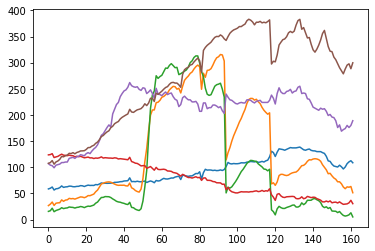

In [63]:
endmembers= np.zeros((162,6))

for ii in range(6): 
    ind = np.where(abundances[ii] > 0.999)[0]
    allPP = X[:,ind]
    endmembers[:,ii] = np.mean(allPP,axis=1)

plt.figure(),plt.plot(endmembers)

**II - Near separable algorithm**

We will here implement the SPA (greedy) near-separable NMF algorithm and look at its practical efficiency.

1) Recall what near-separable NMF is.

<blockquote>Near separable NMF assumes that given a matrix $X \in \mathbb{R}^{m \times t}$, a factorization rank n find Â, Ŝ satisfying: 
$$\hat{A},\hat{S} = argmin_{A \ge 0, S \ge 0 } \frac{1}{2} ||X-X(:,\mathscr{K})S||^2_F$$ such that $|\mathscr{K}| = n$ </blockquote>

2) Implement the SPA algorithm

In [43]:
def simpleSPA(Xin,r,optDisp=False): # TO DO. 
    
    R = Xin.copy()    
    
    K = np.zeros(r)
    
    for ii in range(r):
      normR = np.linalg.norm(R,2,axis=0)
      # Select the column of R with largest l2-norm
      p = np.argmax(normR)
      K[ii] = p
      R = (np.identity(R.shape[0]) - (np.outer(R[:,p],R[:,p].T))/(normR[p]**2))@R
        
      print('Max residual %s'%np.max(R))
    
    return K.astype(int)

3) Launch the SPA algorithm on the toy example.

Plot the residual at each iteration of SPA. 

How many sources can you at most extract ? Why ?

<blockquote>Using the toy example of X, randomly computed above, we can extract at most 33 sources. That is because the value of the Residual gets smaller and smaller, to the point where the maximum norm is Nan, and we can’t extract more sources.<br><br> However, since S is of size nxt, and we are looking for the approximation $X_{\mathscr{K}} \simeq A^*$, it makes sense to take just n sources.</blockquote>

In [44]:
K_SPA = simpleSPA(X_toy,34,optDisp = True)

Max residual 5.002869467851281
Max residual 1.0904874486068608
Max residual 2.895629517820998e-16
Max residual 9.964272996225353e-17
Max residual 5.453607102544037e-17
Max residual 2.940136209660448e-32
Max residual 1.391585899535411e-32
Max residual 7.120373896662145e-33
Max residual 2.683017818723173e-48
Max residual 1.1745788341952434e-48
Max residual 8.742826820671672e-49
Max residual 3.680085641103116e-64
Max residual 1.752479111027235e-64
Max residual 8.13639644282738e-65
Max residual 4.009910886796687e-80
Max residual 3.223085482100545e-80
Max residual 8.641873337498863e-81
Max residual 7.97333453745476e-96
Max residual 3.3632554505325008e-96
Max residual 1.5171031662629592e-96
Max residual 4.125574073164441e-112
Max residual 2.353201374086428e-112
Max residual 1.5015207698831845e-112
Max residual 8.568974295351338e-128
Max residual 5.447329018089453e-128
Max residual 1.3426298374301423e-128
Max residual 4.080786432597517e-144
Max residual 2.96944779328171e-144
Max residual 2.70

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


**4)** The code below enables to compute a separation metric to measure the separation accuracy of the BSS algorithms. 

Use the evalCriterion function to assess the quality of SPA on the real dataset.

Plot the endmembers found by your algorithm. How good are they?

In [45]:
def norm_col(A):
    An = A.copy()
    type(An)
    for ii in range(np.shape(An)[1]):
        An[:,ii] = An[:,ii]/np.sqrt(np.sum(An[:,ii]**2));
    
    return An
        
def correctPerm(W0_en,W_en):
    # [WPerm,Jperm,err] = correctPerm(W0,W)
    # Correct the permutation so that W becomes the closest to W0.
    
    W0 = W0_en.copy()
    W = W_en.copy()
    
    W0 = norm_col(W0)
    W = norm_col(W)
    
    costmat = -W0.T@W; # Avec Munkres, il faut bien un -

    
    m = Munkres()
    Jperm = m.compute(costmat.tolist())
    
    WPerm = np.zeros(np.shape(W0))
    indPerm = np.zeros(np.shape(W0_en)[1])
    
    for ii in range(W0_en.shape[1]):
        WPerm[:,ii] = W_en[:,Jperm[ii][1]]
        indPerm[ii] = Jperm[ii][1]
        
    return WPerm,indPerm.astype(int)

def evalCriterion(W0_en,W_en):
    # W0 : true mixing matrix
    # W : estimated mixing matrix
    #
    # maxAngle : cosine of the maximum angle between the columns of W0 and W
    
    W0 = W0_en.copy()
    W = W_en.copy()
    
    W,indPerm = correctPerm(W0,W);
    
    W0 = norm_col(W0_en)
    W = norm_col(W)

    diff = W0.T@W;
    
    return np.mean(np.diag(diff));

Max residual 603.4173437070264
Max residual 503.62039752697126
Max residual 202.62882898875813
Max residual 180.7841329331175
Max residual 160.9937233096638
Max residual 163.71498109412852
Evaluation Criterion: 0.9149174369799747


(<Figure size 432x288 with 1 Axes>,
  <matplotlib.lines.Line2D at 0x7f484314ead0>])

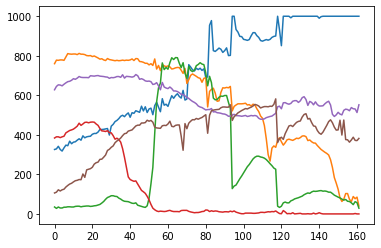

In [73]:
K_SPA = simpleSPA(X,6,optDisp = True)
print("Evaluation Criterion:",evalCriterion(endmembers,X[:,K_SPA]))

plt.figure(),plt.plot(X[:,K_SPA])

<blockquote>As can be seen above, the graph for the estimated endmembers is somewhere similar to the expected one (plotted in the beginning of this section). That is, the overall shapes of the curves are similar (they are in a different order), but the details aren’t.</blockquote>

**5)** (Bonus) The SPA algorithm gives you an estimation of the mixing matrix. Code an ISTA algorithm to obtain the corresponding sources (abundances). Plot them.

**III - PLAIN NMF**

In this part we use the PALM algorithm to perform plain NMF. Of course, if you already coded the PALM algorihtm with sparsity constriant in the previous TP, you can just adapt it.

This optimization scheme is simple but can provide decent separation results.

**1)** Write the cost function of plain NMF.

<blockquote>$$\hat(A),\hat(S) = argmin_{A,S}\frac{1}{2}||X-AS||^2_F = \iota_{.\ge 0}(A)+\iota_{.\ge 0}(S)$$</blockquote>

**2)** Implement the proximal operator of the nonnegativity constraint.

In [74]:
def prox_positive(S): # TO DO
    S = np.maximum(0,S)
    return S

**3)** Implement the PALM algorithm to solve the plain NMF problem.

In [82]:
def PALM(X,n=2,nbIt = 100,Ainit=None,Sinit=None): # TO DO : reutiliser le PALM du TP precedent et l'adapter
    S_est = np.zeros((n,X.shape[1]))
    A_est = np.eye(X.shape[0],n)
    for i in range(nbIt):
      S_est = prox_positive(S_est + (0.9/(np.linalg.norm(A_est.T @ A_est)+1e-16))*(np.dot(A_est.T,(X - np.dot(A_est,S_est)))))
      A_est = prox_positive(A_est + (0.9/(np.linalg.norm(S_est @ S_est.T)+1e-16))*np.dot((X - np.dot(A_est,S_est)),S_est.T))   
    return A_est,S_est

**4)** 
Launch the PALM algorithm on the real hyperspectral dataset. 

Can you find of a better initialization than the random one ?

Compare your result, both qualitatively and quantitatively, with the SPA algorithm. Explain the differences.

Plot the abundances.

In [83]:
# CORRECTION
A_est,S_est = PALM(X,n=6,nbIt = 1000,Ainit=None,Sinit=None) # TO DO: modify the initialization

Evaluation Criterion: 0.930426162237478


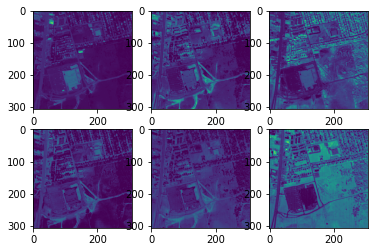

In [95]:
print("Evaluation Criterion:",evalCriterion(endmembers,A_est))
for ii in range(6): 
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(S_est[ii,:].reshape(nCol,nRow))

<blockquote>As can be seen above by the evaluation criterium, the PALM algorithm seems to give a slightly better result than the SPA when compared to the ground truth (0.93 and 0.91 respectively), although it takes considerably longer.<br><br>
Another advantage of the PALM is that it also returns the abundances, that were also plotted above. We can see that they all appear to the original sources. We can see clearly the one that corresponds to the grass, the rooftops, etc. However, they aren’t as clear or as separable as the original.
 
</blockquote>

**IV - MINIMUM VOLUME NMF**

We finish this TP with the utilization of minimum volume NMF. As coding the corresponding algorithm is slightly above the objective of the classes, the code is fully given below.

In [100]:
def simplexProx(X,epsilon = 0):
#     Given X,  computes its projection Y onto the simplex  

#       Delta = { x | x >= 0 and sum(x) <= 1 }, 

# that is, Y = argmin_z ||x-X||_2  such that z in S. 

# If X is a matrix, is projects its columns onto Delta to generate Y.


# ****** Input ****** 
# X       : m-by-r matrix
# epsilon : r-by-1 vector, generally positive and taken = 0

# ****** Output ****** 
# Y       : the projected matrix

    
    if np.isscalar(epsilon) == 1:
        epsilon = epsilon*np.ones(np.shape(X)[1]) 
    
    Y = np.zeros(np.shape(X))
    
    for ii in range(np.shape(X)[1]): # The prox is separable over the columns of X
        x = X[:,ii].copy() # We work on each column separately
        xsort = np.sort(x) # We need to sort the x value to apply the dichotomy
    
        index_min=0 # Index values for the dichotomy
        index_max=len(x)-1;
        
        # mu s.t. x_i > mu-epsilon, forall i
        mu_min=xsort[0]+epsilon[ii] # mu is the parameter required for the projection
    
        min_sum=np.sum(x)-len(x)*mu_min
        
        if min_sum < 1:# If the vector already satisfies the sum to at most one constraint
            mu=(np.sum(x)-1.)/np.float(len(x))
            y=np.maximum(-epsilon[ii]*np.ones(len(x)), x-mu) # Element-wise max
            Y[:,ii]=y;
        else:
            # Use dichotomy for finding the optimal mu value
            stop = False
            it = 0
            while stop == False:
                it += 1
                
                cur_ind = int(np.round((float(index_min)+float(index_max)+1e-6)/2.))
                mu=xsort[cur_ind]+epsilon[ii]
                y=np.maximum(-epsilon[ii]*np.ones(len(x)), x-mu)
                
                val_constr = np.sum(y)
                if val_constr < 1.:
                    index_max=cur_ind # Because the objective is decreasing with mu and indMax > indMin
                elif val_constr > 1.:
                    index_min=cur_ind
                    
                else: # We found the best mu
                    Y[:,ii]=y
                    stop = True
                    
                    
                if index_max == index_min + 1:# This is a stopping condition, as the constraint function is piecewise linear
                    stop = True
                    
                    
            mu_inf=xsort[index_min]+epsilon[ii];
            mu_sup=xsort[index_max]+epsilon[ii];
            constr_inf = np.sum(np.maximum(-epsilon[ii]*np.ones(len(x)),x-mu_inf))
            constr_sup = np.sum(np.maximum(-epsilon[ii]*np.ones(len(x)),x-mu_sup))
                
            slope=(constr_sup-constr_inf)/(mu_sup-mu_inf)
            mu_opt=(1.-constr_inf)/slope+mu_inf # Because the constraint function is piecewise linear
            
            # Compute the corresponding column of Y
            y=np.maximum(-epsilon[ii]*len(x), x-mu_opt)
            
            Y[:,ii]=y
            
            
            
    return Y




#%%
def FGM_MM_nonneg(A,C,W0=0,maxiter=500,proj=1):
    # Fast gradient method to solve nonnegative least squares.  
    # See Nesterov, Introductory Lectures on Convex Optimization: A Basic 
    # Course, Kluwer Academic Publisher, 2004. 
    
    # This code solves: 
    
    #     min_{x_i in R^r_+} sum_{i=1}^m ( x_i^T A x_i - 2 c_i^T x_i ), if proj == 1
    #     min_{x_i in S} sum_{i=1}^m ( x_i^T A x_i - 2 c_i^T x_i ), if proj == 2 (with S = simplex)
    # [W,e] = FGMfcnls(A,C,W0,maxiter) 
    
    # ****** Input ******
    # A      : Hessian for each row of W, positive definite
    # C      : linear term <C,W>
    # W0     : m-by-r initial matrix
    # maxiter: maximum numbre of iterations (default = 500). 
    # proj   : =1, nonnegative orthant
    #          =2, nonnegative orthant + sum-to-one constraints on columns
    #
    # ****** Output ******
    # W      : approximate solution of the problem stated above. 
    # e      : e(i) = error at the ith iteration

    if np.isscalar(W0):
        W0 = np.zeros(np.shape(C));

    L = np.linalg.norm(A,2)# Pas evident...
    e = np.zeros(maxiter)
    # Extrapolation parameter
    beta = (1.-np.sqrt(np.linalg.cond(A))) / (1. + np.sqrt(np.linalg.cond(A))); 
    
    # Project initialization onto the feasible set
    if proj == 1:
        W = np.maximum(W0,0)
    elif proj == 2:
        W = simplexProx(W0)
        
    
    Y = W # Initialization of the second sequence (for the acceleration)
    ii = 0;
    eps0 = 0.
    eps = 1.
    delta = 1e-6
    
    while ii < maxiter and eps >= delta*eps0:
        # print("FGM_MM_nonneg, it %s"%ii)
        # Previous iterate
        Wp = W
        
        # FGM Coefficients  
        # alpha(i+1) = ( sqrt(alpha(i)^4 + 4*alpha(i)^2 ) - alpha(i)^2) / (2); 
        # beta(i) = alpha(i)*(1-alpha(i))/(alpha(i)^2+alpha(i+1)); 
        
        # Projected gradient step from Y
        W = Y - (Y@A-C) / L 
        
        # Projection
        if proj == 1:
            W = np.maximum(W,0.)
        elif proj == 2:
            W = simplexProx( W )
            
        
        # Linear combination of iterates
        Y = W + beta*(W-Wp)
        
        # Error
        e[ii] = np.sum((W.T@W)*A) - 2.*np.sum(W*C)
        
        
        # Restart: fast gradient methods do not guarantee the objective
        # function to decrease, a good heursitic seems to restart whenever it
        # increases although the global convergence rate is lost! This could
        # be commented out. 
        
        if ii >= 2 and e[ii] > e[ii-1]:
            Y = W
            
        if ii == 1:
            eps0 = np.sqrt(np.sum((W-Wp)**2))
        
        eps = np.sqrt(np.sum((W-Wp)**2))
        
        ii += 1
    return W,e

#%%
def nnls_FPGM(X,W,delta=1e-6,inneriter=500,proj=0,alpha0=0.05,H = 0,options=0 ):

     # Computes an approximate solution of the following nonnegative least
     # squares problem (NNLS)
    
     #           min_{H >= 0} ||X-WH||_F^2
     
     # using a fast gradient method; 
     # See Nesterov, Introductory Lectures on Convex Optimization: A Basic 
     # Course, Kluwer Academic Publisher, 2004. 
     
     # Input / Output; see nnls_input_output.m  
     
     # + options.proj allows to use a contraints on the columns or rows of H so 
     #   that the entries in each column/row sum to at most one 
     #   options.proj = 0: no projection (default). 
     #   options.proj = 1: projection of the columns on {x|x>=0, sum(x) <= 1} 
     #   options.proj = 2: projection of the rows {x|x>=0, sum(x) = 1} 
          
     # + options.alpha0 is the FPGM  extrapolation parameter (default=0.05). If options.alpha0 = 0 --> no acceleration, PGM
    

   
    
    # If no initial matrices are provided, H is initialized as follows: 
    if np.isscalar(H):
        H = np.zeros((np.shape(W)[1],np.shape(X)[1]))

    
    # Hessian and Lipschitz constant 
    WtW = W.T@W
    L = np.linalg.norm(WtW,2)
    # Linear term 
    WtX = W.T@X

    alpha = np.zeros(inneriter + 1)
    beta = np.zeros(inneriter)
    alpha[0] = alpha0
    
    if options == 0: # Project onto the non-negative orthant
        H = np.maximum(H,0)
    elif options == 1: # Project columns of H onto the simplex and origin
        H = np.maximum(H,0) 
        K = np.where(np.sum(H,axis=0) > 1.)[0] 
        H[:,K] = simplexProx( H[:,K] ) 
    elif options == 2: # Project rows of H onto the simplex
        H = simplexProx(H.T)
        H = H.T 
    
    
    
    Y = H # Second sequence
    ii = 0
    # Stop if ||V^{k}-V^{k+1}||_F <= delta * ||V^{0}-V^{1}||_F
    eps0 = 0
    eps = 1  
    while ii < inneriter and eps >= delta*eps0:
        # Previous iterate
        Hp = H; 
        # FGM Coefficients; see Nesterov's book
        alpha[ii+1] = ( np.sqrt(alpha[ii]**4 + 4*alpha[ii]**2 ) - alpha[ii]**2) / 2.
        beta[ii] = alpha[ii]*(1.-alpha[ii])/(alpha[ii]**2+alpha[ii+1])
        # Projection step
        H = Y - (WtW@Y-WtX) / L
        
        if options == 0:
            H = np.maximum(H,0);
        elif options == 1:
            H = np.maximum(H,0) # Project columns of H onto the set {x|x>=0, sum(x) <= 1} 
            K = np.where(np.sum(H,axis=0) > 1.)[0]
            H[:,K] = simplexProx( H[:,K] )  
        elif options == 2:
            H = simplexProx(H.T) # Project rows of H onto the simplex
            H = H.T
        
        # Linear combination of iterates
        Y = H + beta[ii]*(H-Hp)
        if ii == 1:
            eps0 = np.linalg.norm(H-Hp,'fro')
        
        eps = np.linalg.norm(H-Hp,'fro')
        ii = ii + 1; 
      


    return H,WtW,WtX





#%%
def normalizeWH(W,H,sumtoone,X): 
    # Normalization depending on the NMF model 
    if sumtoone == 1: # Normalize so that H^Te <= e entries in cols of H sum to at most 1
                      
        Hn = simplexProx( H );
        if np.linalg.norm(Hn - H) > 1e-3*np.linalg.norm(Hn):
           H = Hn
           # Reoptimize W, because this normalization is NOT w.l.o.g. 
           W,WtW_temp,WtX_temp = nnls_FPGM(X.T,H.T,H = W.T,inneriter=100)
           W = W.T
        
        H = Hn 
        
    elif sumtoone == 2: # Normalize so that He = e, entries in rows of H sum to 1
        scalH = np.sum(H,axis=1)
        H = np.diag( scalH**(-1) )@H
        W = W@np.diag( scalH )
        
    elif sumtoone == 3: # Normalize so that W^T e = e, entries in cols of W sum to 1
        scalW = np.sum(W,axis=0)
        H = np.diag( scalW )@H
        W = W@np.diag( scalW**(-1) )


    return W,H


#%%
def minvolNMF(X,r,W,H,lamb=0.1,delta=0.1,model=3,maxiter=100,inneriter=10,target = None):
    # W,H : initializations (W par SNPA, H par NNLS)

    # Normalization
    W,H = normalizeWH(W,H,model,X) # OM pour modele 2
    # Initializations
    normX2 = np.sum(X**2)
    normX = np.sqrt(normX2)
    
    WtW = W.T@W;
    WtX = W.T@X;
    
    err1 = np.zeros(maxiter)
    err2 = np.zeros(maxiter)
    e = np.zeros(maxiter)
    
    # Initial error and set of of lambda
    err1[0] = np.maximum(0,normX2-2.*np.sum(WtX*H)+np.sum(WtW*(H@H.T)))
    err2[0] = np.log(np.linalg.det(WtW + delta*np.eye(r)));  #OK
    
    lamb = lamb * np.maximum(1e-6,err1[0]) / (np.abs( err2[0] ))
    
    e[0] =  err1[0] + lamb * err2[0] # OK

    
    
    # projection model for H
    if model == 1:
        proj = 1
    elif model == 2:
        proj = 2
    elif model == 3:
        proj = 0
    
    
    # Main loop 
    
    for ii in range(1,maxiter):
        #*** Update W ***
        XHt = X@H.T
        HHt = H@H.T
        
        Y = np.linalg.inv( ( W.T@W + delta*np.eye(r) ) )
        A = lamb*Y + HHt
        
        if model <= 2:
            W,irr = FGM_MM_nonneg(A,XHt,W,inneriter,proj=1)
        elif model == 3:
            W,irr = FGM_MM_nonneg(A,XHt,W,inneriter,proj=2)

        # *** Update H ***
        Hinit = H
        
        H,WtW,WtX = nnls_FPGM(X,W,H=Hinit,proj=proj,inneriter=inneriter,delta=delta)
        
        err1[ii] = np.maximum(0, normX2 - 2.*np.sum(WtX*H)  + np.sum(WtW*(H@H.T)))
        err2[ii] = np.log(np.linalg.det(WtW + delta*np.eye(r)))
        
        e[ii] = err1[ii] + lamb * err2[ii]
        
        # Tuning lambda to obtain options.target relative error
        if np.isscalar(target):
            if np.sqrt(err1[ii])/normX > target+0.001:
                lamb = lamb*0.95
            elif np.sqrt(err1[ii])/normX < target-0.001:
                lamb = lamb*1.05
                
                
    return W,H,e,err1,err2

**1)** Launch the minvolNMF algorithm, by finding a good initialisation.

In [105]:
S_toy = np.random.rand(abundances.shape[0],abundances.shape[1])
A_toy = np.random.rand(endmembers.shape[0],endmembers.shape[1])
[W3_t,H3_t,e3_t,er13_t,er23_t] = minvolNMF(X,6,A_toy,S_toy,lamb=1.,delta=0.1,model=1,maxiter=1000,inneriter=10,target = 0.05)

**2)** Compute the separation metric with the result of the minVol algorithm. Plot the abundances. Conclude on the different NMF algorithms.

Evaluation Criterion: 0.9879178894725319


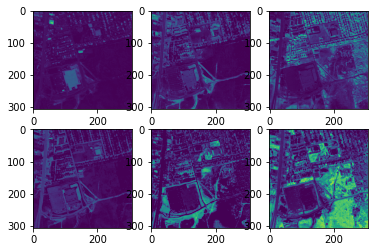

In [102]:
print("Evaluation Criterion:",evalCriterion(endmembers,W3_t))
for ii in range(6): 
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(H3_t[ii,:].reshape(nCol,nRow))

<blockquote>Both quantitative and qualitative the minimum volume NMF seems to give the best results of all the methods tried in this TP. It’s also faster than the PALM algorithm. As can be seen above, the evaluation criterium is equal to almost 0.99 and the abundances are clearer and sharper, unlike the PALM.<br><br>
At last, the finding a good initialization didn’t seem to pose problems, as a random one already gave us pretty good results.</blockquote>